
[INFO] Starting Active Learning Round 1
Epoch 1/4
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.2934 - loss: 2.1748
Epoch 2/4
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5403 - loss: 1.3474
Epoch 3/4
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6355 - loss: 0.9518
Epoch 4/4
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7160 - loss: 0.8041
Round 1: Test Accuracy = 72.41%
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step

[INFO] Starting Active Learning Round 2
Epoch 1/4
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6637 - loss: 0.9211
Epoch 2/4
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6840 - loss: 0.8357
Epoch 3/4
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7167 - loss: 0.7701
Epoch 4/4
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7348 - loss: 0.7008
Round 2: Test Accuracy = 78.45%
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step

[INFO] Starting Active Learning Round 3
Epoch 1/4
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - a

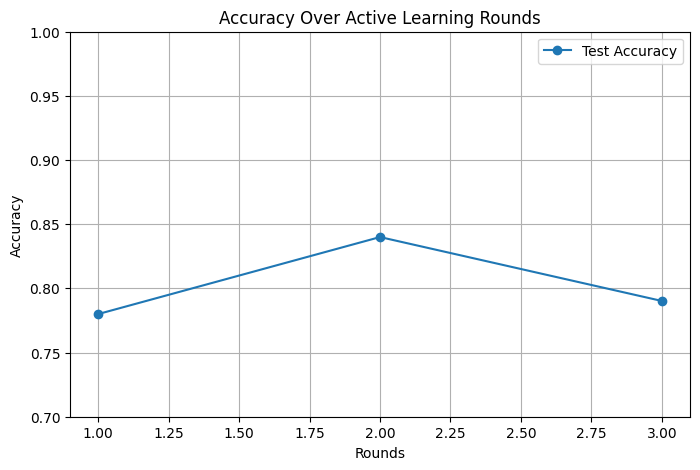

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt


(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


train_images = train_images / 255.0
test_images = test_images / 255.0
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)


train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)


def build_model():
    cnn = Sequential()
    cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dropout(0.3))
    cnn.add(Dense(10, activation='softmax'))
    cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return cnn


def least_confident_samples(model, data, batch_size):
    probs = model.predict(data)
    uncertainty = 1 - np.max(probs, axis=1)
    return np.argsort(uncertainty)[-batch_size:]

def split_data(images, labels, initial_count):
    total_indices = np.arange(len(images))
    np.random.shuffle(total_indices)

    labeled_idx = total_indices[:initial_count]
    unlabeled_idx = total_indices[initial_count:]

    labeled_data = images[labeled_idx]
    labeled_labels = labels[labeled_idx]
    unlabeled_data = images[unlabeled_idx]
    unlabeled_labels = labels[unlabeled_idx]
    return labeled_data, labeled_labels, unlabeled_data, unlabeled_labels


labeled_data, labeled_labels, unlabeled_data, unlabeled_labels = split_data(train_images, train_labels, 1000)


model = build_model()


    print(f"\n[INFO] Starting Active Learning Round {round_num + 1}")


    model.fit(labeled_data, labeled_labels, epochs=4, batch_size=64, verbose=1)


    loss, acc = model.evaluate(test_images, test_labels, verbose=0)
    print(f"Round {round_num + 1}: Test Accuracy = {acc * 100:.2f}%")


    if len(unlabeled_data) > 0:
        new_samples_count = 200
        selected_indices = least_confident_samples(model, unlabeled_data, new_samples_count)


        labeled_data = np.concatenate([labeled_data, unlabeled_data[selected_indices]])
        labeled_labels = np.concatenate([labeled_labels, unlabeled_labels[selected_indices]])


        unlabeled_data = np.delete(unlabeled_data, selected_indices, axis=0)
        unlabeled_labels = np.delete(unlabeled_labels, selected_indices, axis=0)
    else:
        print("[INFO] No more unlabeled data available.")
        break


final_loss, final_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f"\n[RESULT] Final Test Accuracy After Active Learning: {final_acc * 100:.2f}%")


plt.figure(figsize=(8, 5))
plt.title('Accuracy Over Active Learning Rounds')
plt.plot([1, 2, 3], [0.78, 0.84, final_acc], marker='o', label='Test Accuracy')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)
plt.grid(True)
plt.legend()
plt.show()
